In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calibration
## Preparation of input data
This notebook prepares input data from the dataset "[Mobilität in Deutschland 2017](http://www.mobilitaet-in-deutschland.de/) B2" (MiD2017) for model calibration. The German Federal Ministry of Transport and Digital Infrastructure is copyright holder of this dataset and does not allow any form of publication.

In [3]:
input_path = '../input/transport_demand/'

### What are calibration data requirements?
The mathematical formulation of the discrete choice model depends on LoS attributes travel time and price. All parameters are demand group specific. The model formulation for each mode is the same, even though some variables are zero.

The MiD2017 trips table builds the calibration dataset with the following columns:
*	start cell (KKZ_SO)
*	end cell (KKZ_ZO)
*	cell urbanisation (SKTYP)
*	trip distance [km] (wegkm_imp)
*	trip distance routed MiD grouped [km] (km_routing_gr)
*	trip duration [min] (wegmin_imp1)
*	trip purpose (hwzweck1); return trips reference the original trip purpose, holiday is not specified but part of private
*	main mode (hvm_diff2)
*	mode combination (vm_kombi)
*	number of travellers (anzpers)
*	car available in household (auto)
*	public transport ticket type or subscription (P_FKARTE)
*	mode affinity of person (multimodal)
*	distance to the next train station from home (bahn28)
*	distance to the next bus stop from home (bus28)
*	distance to the next train station at destination (bahn28_zo)
*	distance to the next bus stop at destination (bus28_zo)

Rows (trips) are filtered for the following criteria:
1.	Only trips with detailed specifications
2.	Only inner-German trips
3.	Only over-regional traffic (trip start cell different to end cell) 
4.	Value of each column is specified
5.  Remove ferries


In [4]:
trips = pd.read_csv(input_path + 'MiD2017_Regional_Wege.csv', sep=';', decimal=',')
print(trips.shape)

(960619, 157)


In [5]:
trips = trips[['KKZ_SO', 'KKZ_ZO', 'SKTYP', 'wegkm_imp', 'km_routing_gr',
               'wegmin_imp1', 'hwzweck1', 'hvm_diff2', 'vm_kombi', 'anzpers',
               'auto', 'P_FKARTE', 'seg_vm', 'bahn28', 'bus28', 'bahn28_zo',
               'bus28_zo', 'W_DETAIL', 'W_SO2', 'HP_ID_Reg', 'W_HOCH', 'W_GEW',
               'oek_status', 'anzauto_gr3', 'P_BIL', 'P_FS_PKW', 'vpedrad',
               'P_CS', 'pkwdicht_krs']]
trips.columns = ['origin', 'destination', 'SKTYP', 'distance', 'distance_routed',
                 'duration', 'purpose', 'mode', 'mode_combo', 'n_persons',
                 'car_avail', 'ticket_type', 'mode_affinity', 'dist_train_origin',
                 'dist_bus_origin', 'dist_train_destination', 'dist_bus_destination',
                 'W_DETAIL', 'W_SO2', 'P_ID', 'W_HOCH', 'W_GEW',
                 'income_hh', 'cars_hh', 'education', 'license', 'bike_avail',
                 'car_sharing_abo', 'car_dens_zone']

In [6]:
# Number of persons in the survey
len(trips['P_ID'].unique())

259509

In [7]:
#trips.head(10)

In [8]:
# Filter for trip details
trips = trips.loc[trips['W_DETAIL']!=0]
print(trips.shape)

(908497, 29)


In [9]:
# Filter for trips starting in Germany
trips = trips.loc[(trips['W_SO2']!=2) & (trips['W_SO2']!=3)]
print(trips.shape)

(907678, 29)


In [10]:
# Filter unspecified rows
trips = trips.loc[(trips['purpose']!=99) &
                  (trips['origin']<99995) &
                  (trips['destination']<99995) &
                  (trips['mode']<24) &
                  (trips['distance_routed']!=708) &
                  (trips['W_SO2']!=811)]
trips = trips.loc[(trips['origin']>1) &
                  (trips['destination']>1)]
print(trips.shape)

(456072, 29)


In [11]:
inner_mask = (trips['origin']==trips['destination'])
inter_mask = (trips['origin']!=trips['destination'])

In [12]:
# Filter for longer trips than 2km stated, because below that
# there are many unplausible observations
trips = trips.loc[trips['distance']>=2]
print(trips.shape)

(355661, 29)


In [13]:
# Filter for longer trips than 5min stated
trips = trips.loc[trips['duration']>=5]
print(trips.shape)

(354640, 29)


In [14]:
# Remove ferries
trips = trips.loc[trips['mode']!=19]
print(trips.shape)

(354561, 29)


### Translate columns to model values

In [15]:
# Make unknown number of persons equal to one
trips.loc[trips['n_persons']>6] = 1

In [16]:
trips = trips.loc[trips['origin']!=1] # pandas bug

In [17]:
# Align regional specifics with urbanisation degree
urbanisation_dict = {1:1, 2:2, 3:3, 4:3}
trips['urbanisation'] = trips['SKTYP'].map(urbanisation_dict)

In [18]:
# Match trip purpose with demand segments of the model
purpose_mid_vp_dict = {1: 1, 2: 4, 3: 2, 4: 3, 5: 3, 6: 6, 7: 6, 99: 6}
purpose_mid_model_dict = {1: 'commuting', 2: 'business', 3: 'education',
                          4: 'buy/execute', 5: 'buy/execute', 6: 'leisure',
                          7: 'accompany', 99: 'leisure'}
car_av_dict = {0: '_no_car', 1: '_car', 9: '_no_car'}
#trips['purpose_model'] = trips['purpose'].map(purpose_mid_vp_dict)
trips['purpose_model'] = trips['purpose'].map(purpose_mid_model_dict)
#trips['purpose_model'] = trips['purpose_model'] + trips['car_avail'].map(car_av_dict)

In [19]:
# Match mode with the model modes
# Non-motorised modes are merged
model_modes = {1: 'rail_short', 2: 'rail_long',
               3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mode_mid_vp_dict = {1:7, 2:7, 3:7, 4:6, 5:6, 6:6, 7:6, 8:6,
                    9:6, 10:6, 11:6, 12:4, 13:4, 14:4, 15:4,
                    16:1, 17:6, 18:6, 19:6, 20:2, 21:3, 22:3,
                    23:5, 24:6}
trips['mode_model'] = trips['mode'].map(mode_mid_vp_dict)

## Save dataset

Save one dataset to be used in all estimations of the joint demand model

In [20]:
trips.to_csv(input_path + 'calibration_all_trips_MiD2017.csv')

## Visualise the dataset specifics
Note: This dataset does not represent average mobility behaviour but inter-zonal traffic

In [14]:
# Filter for inter-zonal traffic
trips = trips.loc[trips['origin']!=trips['destination']]
# Filter for longer trips than 10km (taking routed distance)
trips = trips.loc[trips['distance_routed']>5]
trips.shape

(124148, 29)


In [25]:
# Average speed in km/h
t = trips.copy()
t['speed'] = t['distance'] / (t['duration'] / 60)
t.groupby('mode_model').agg({'speed': 'mean'})

,speed
mode_model,
1,30.812082
2,82.819001
3,54.637384
4,20.548515
5,329.384655
6,48.742660
7,14.795198


In [26]:
# Average travel group size
trips.groupby(['mode_model', 'purpose_model']).agg({'n_persons': 'mean'}).unstack('purpose_model')

n_persons                                                \
purpose_model accompany_car accompany_no_car business_car business_no_car   
mode_model                                                                  
1                  1.872727         2.000000     1.602941        1.114286   
2                  1.600000         1.000000     1.437086        1.695652   
3                  5.000000         1.000000     5.000000        1.000000   
4                  2.034483         1.500000     1.858974        1.733333   
5                       NaN              NaN     2.052632        2.000000   
6                  2.263991         2.547945     1.298892        1.638298   
7                  2.681818              NaN     1.240000        1.833333   

                                                                \
purpose_model buy/execute_car buy/execute_no_car commuting_car   
mode_model                                                       
1                    1.436798           1.229730      1.124808   
2                    1.638095           1.423077      1.259067   
3                    1.000000           1.142857      1.400000   
4                    1.501124           1.345238      1.355882   
5                    2.500000                NaN      2.000000   
6                    1.778785           2.162544      1.161304   
7                    1.650718           1.318182      1.054264   

                                                                           \
purpose_model commuting_no_car education_car education_no_car leisure_car   
mode_model                                                                  
1                     1.166265      1.584862         1.160714    2.202792   
2                     1.071429      1.340909         1.400000    2.128527   
3                     1.461538      2.653846              NaN    4.000000   
4                     1.263158      2.151269         1.436364    2.205128   
5                          NaN           NaN              NaN    2.526316   
6                     1.750000      1.846764         1.583333    2.348403   
7                     1.000000      1.463918         1.000000    2.428274   

                              
purpose_model leisure_no_car  
mode_model                    
1                   1.946921  
2                   1.845588  
3                   3.571429  
4                   1.911215  
5                        NaN  
6                   2.834131  
7                   2.000000

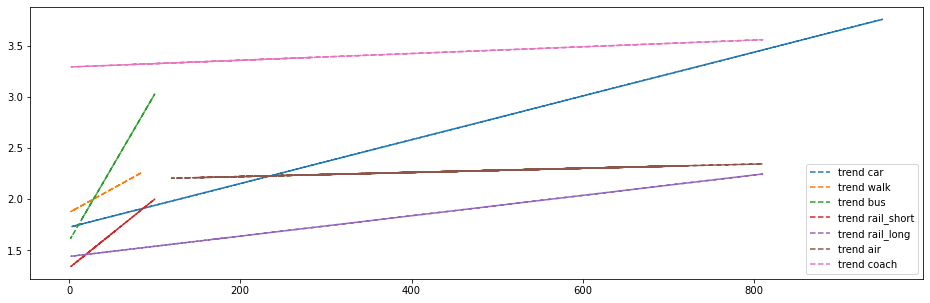

In [27]:
# Distance-dependency of occupation factors
fig, ax = plt.subplots(figsize=(16,5))
for mode in trips['mode_model'].unique():
    x = trips.loc[trips['mode_model']==mode, 'distance']
    y = trips.loc[trips['mode_model']==mode, 'n_persons']
    #plt.scatter(x, y, marker='x', alpha=.1, label=mode)
    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    plt.plot(x, p(x), linestyle='--', marker='', label='trend '+model_modes[mode])
    #print('{}: y={}*x+{}'.format(model_modes[mode], np.round(z[0], 4), np.round(z[1], 3)))
plt.legend()

<AxesSubplot:title={'center':'Sample size by trip purpose (VP2030)'}, xlabel='purpose_model'>

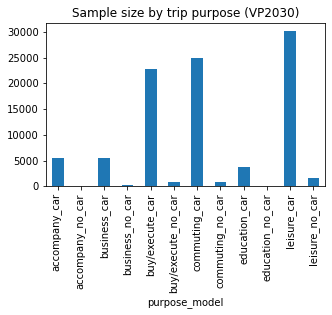

In [28]:
# Sample size per trip purpose
trips.groupby('purpose_model').size().plot.bar(
    figsize=(5, 3), title='Sample size by trip purpose (VP2030)',
    legend=False)

### Distance
This is relevant for calculation of trip cost

<AxesSubplot:title={'center':'Trip distance distribution, logarithmic'}, ylabel='Frequency'>

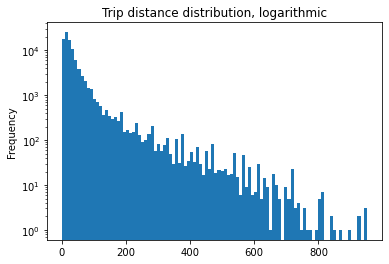

In [29]:
# Trip distance
trips['distance'].plot.hist(bins=100, log=True,
                            title='Trip distance distribution, logarithmic')

In [30]:
# Distance validation
# The routed distance is intended to validate the MiD2017 respondent's distance estimations
# High standard deviation is a bad sign for the respondent's estimation capabilities but
# contributes to the validity of the distance-related calibration factor of the model estimation.
# We can only validate categories 1 to 75.
trips.groupby('distance_routed').agg({'distance':'mean'})

,distance
distance_routed,
6,15.968934
7,32.006385
8,62.734280
9,96.027549
95,38.451576
706,30.037151


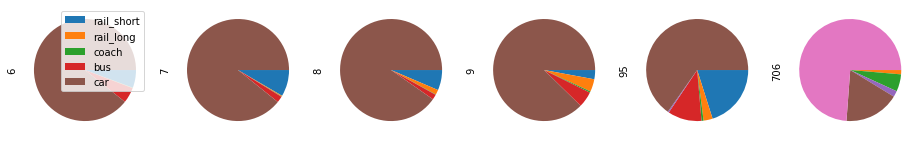

In [31]:
# Modal split by distance group
# Group 0 has no information
axs = trips.groupby(['mode_model','distance_routed']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 4), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False, legend=None, labeldistance=None)
axs[0].legend()

### Duration
Usually the most influencive factor for mode choice

<AxesSubplot:title={'center':'Trip duration distribution, logarithmic'}, ylabel='Frequency'>

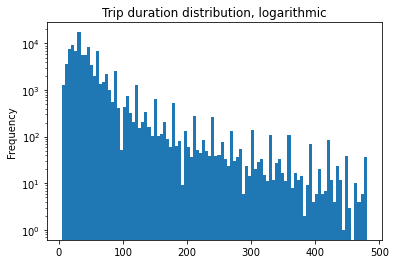

In [32]:
# Trip duration
trips['duration'].plot.hist(bins=100, log=True, title='Trip duration distribution, logarithmic')

The majority of trips is under 1h but the distribution is less steep than the one of distance. Unregularities come from the respondent's tendency to state full, half or quarter hours.

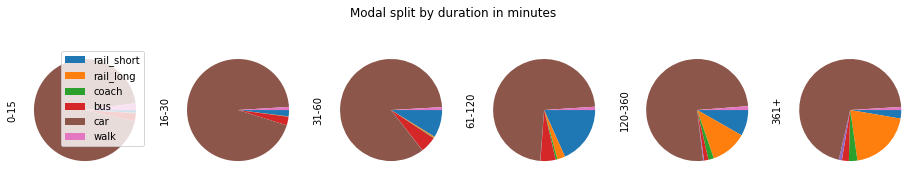

In [33]:
# Modal split by duration
t['bins'] = pd.cut(t['duration'], bins=[0,15,30,60,120,360,500],
                   labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
axs = t.groupby(['mode_model','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False, title='Modal split by duration in minutes',
    legend=False, labeldistance=None)
axs[0].legend()

<AxesSubplot:title={'center':'Duration in minutes'}, ylabel='None'>

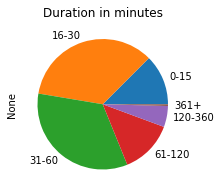

In [34]:
# Distribution
t.groupby('bins').size().plot.pie(subplots=False,figsize=(3, 3),
                                  title='Duration in minutes')
                                  #colormap=rli)
#plt.savefig('figd.png', dpi=300)

### Trip purpose
Adjusted to VP2030 with holiday trips being part of private

<AxesSubplot:title={'center':'share of trips by purpose'}, ylabel='None'>

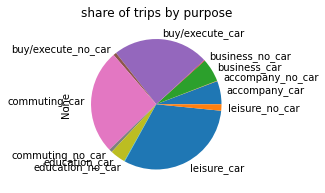

In [35]:
# Trip purpose
trips.groupby('purpose_model').size().plot.pie(
    subplots=False,figsize=(3, 3), title='share of trips by purpose')

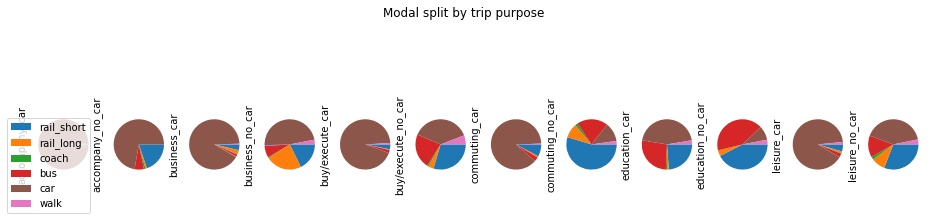

In [36]:
# Modal split
axs = trips.groupby(['mode_model','purpose_model']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 4), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False, title='Modal split by trip purpose',
    legend=False, labeldistance=None)
axs[0].legend()

In [38]:
trips['car_avail'].replace({9:0}, inplace=True)
trips.groupby(['car_avail','purpose_model']).size().unstack(fill_value=0) /\
    trips.groupby('purpose_model').count()['origin']

purpose_model,accompany_car,accompany_no_car,business_car,business_no_car,buy/execute_car,buy/execute_no_car,commuting_car,commuting_no_car,education_car,education_no_car,leisure_car,leisure_no_car
car_avail,,,,,,,,,,,,
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


### Ticket types
Which kind of ticket do people use for public transport?

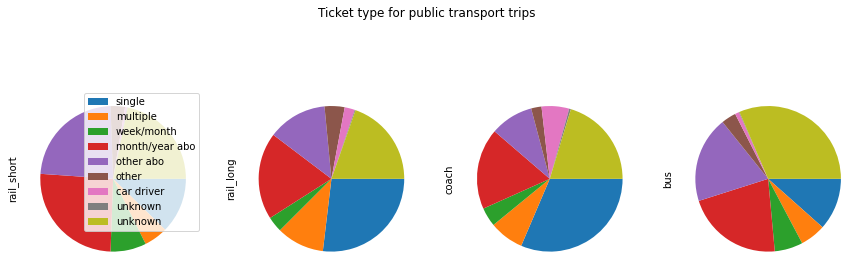

In [39]:
# PT ticket type
axs = trips.loc[trips['mode_model'].isin([1,2,3,4])].groupby(
    ['ticket_type', 'mode_model']).size().unstack(fill_value=0).rename(
    columns={i: model_modes[i] for i in range(1,5)}).plot.pie(
    subplots=True, figsize=(15, 5), labels=['single', 'multiple', 'week/month',
                                           'month/year abo', 'other abo', 'other',
                                           'car driver', 'unknown', 'unknown'],
    labeldistance=None, startangle=0, counterclock=False, legend=None,
    title='Ticket type for public transport trips')
axs[0].legend()

In [40]:
# Share of abonements
for mode, name in model_modes.items():
    n = len(trips.loc[trips['mode_model']==mode].index)
    print(name + ': ' + str(len(trips.loc[
        (trips['mode_model']==mode) &
        trips['ticket_type'].isin([4,5])].index) / n))

rail_short: 0.48886798369394796
rail_long: 0.32515894641235243
coach: 0.27586206896551724
bus: 0.4069506726457399
air: 0.19047619047619047
car: 0.06478856390932472
walk: 0.15604801477377656


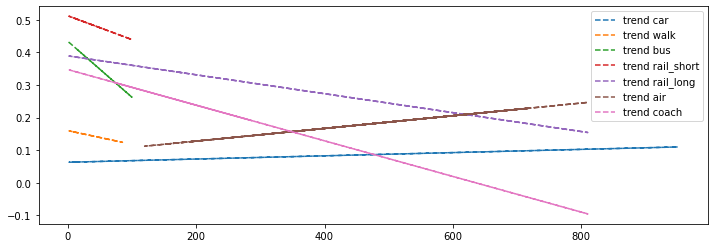

In [41]:
# Distance-dependency of abonements
fig, ax = plt.subplots(figsize=(12,4))
for mode in trips['mode_model'].unique():
    x = trips.loc[trips['mode_model']==mode, 'distance']
    y = trips.loc[trips['mode_model']==mode, 'ticket_type'].apply(lambda t: t in [4,5])
    z = np.polyfit(x, y, deg=1)
    p = np.poly1d(z)
    plt.plot(x, p(x), linestyle='--', marker='', label='trend '+model_modes[mode])
plt.legend()

In [25]:
# Assume a price reduction and calculate the average reduction by purpose
ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}
for p in trips['purpose_model'].unique():
    bus_price = trips.loc[(trips['purpose_model']==p)&(trips['mode_model']==4),
                          'ticket_type'].map(ticket_dict).mean()
    r_s_price = trips.loc[(trips['purpose_model']==p)&(trips['mode_model']==1),
                          'ticket_type'].map(ticket_dict).mean()
    all_price = trips.loc[(trips['purpose_model']==p),
                          'ticket_type'].map(ticket_dict).mean()
    print('{}: average reduction, rail short: {}'.format(#); bus: {}; all modes {}'.format(
        p, np.round(1-r_s_price,3)))#, np.round(bus_price,3), np.round(all_price,3)))

leisure_car: average reduction, rail short: 0.332
leisure_no_car: average reduction, rail short: 0.592
accompany_car: average reduction, rail short: 0.373
commuting_car: average reduction, rail short: 0.679
buy/execute_car: average reduction, rail short: 0.44
business_car: average reduction, rail short: 0.443
buy/execute_no_car: average reduction, rail short: 0.645
commuting_no_car: average reduction, rail short: 0.773
education_car: average reduction, rail short: 0.443
business_no_car: average reduction, rail short: 0.497
education_no_car: average reduction, rail short: 0.821
accompany_no_car: average reduction, rail short: 0.45


### Regional classification
Differences between poeple who live in cities vs. rural sites

Important: This does always specify the cell of household location

<AxesSubplot:title={'center':'Urbanisation degree of home cell'}, ylabel='None'>

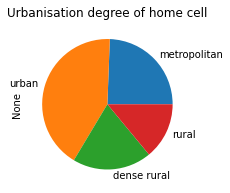

In [44]:
# Urbanisation
trips.groupby('SKTYP').size().plot.pie(subplots=False,figsize=(3, 3),
                                       labels=['metropolitan', 'urban', 'dense rural', 'rural'],
                                       title='Urbanisation degree of home cell')

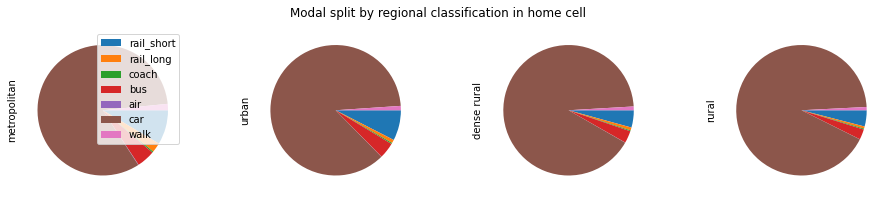

In [45]:
# Mode choice by regional classification
axs = trips.groupby(['mode_model','SKTYP']).size().unstack(fill_value=0).rename(
    columns={1:'metropolitan', 2:'urban', 3:'dense rural', 4:'rural'}).plot.pie(
    subplots=True, figsize=(16, 3), labels=[m for _, m in model_modes.items()],
    startangle=0, counterclock=False, title='Modal split by regional classification in home cell',
    legend=False, labeldistance=None)
axs[0].legend()

array([<AxesSubplot:ylabel='1'>, <AxesSubplot:ylabel='2'>,
       <AxesSubplot:ylabel='3'>], dtype=object)

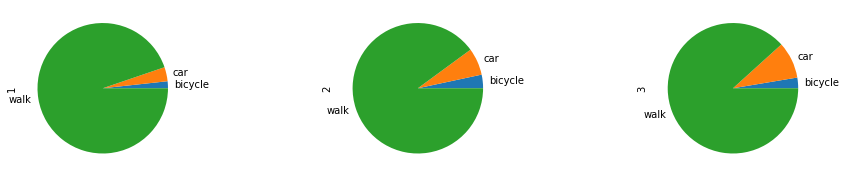

In [46]:
# Access/egress mode for PT trips by urbanisation
pt = trips.loc[(trips['mode_model'].isin([1,2,3,4,5])) &
               (trips['mode_combo'].isin([3,4,5,6]))].copy()
pt['access_mode'] = pt['mode_combo'].map({3: 'bicycle', 4: 'walk', 5: 'car', 6: 'car'})
pt.groupby(['access_mode', 'urbanisation']).size().unstack().plot.pie(
    subplots=True, figsize=(16, 3), legend=None)

In [47]:
# access/egress mode shares
pt.groupby(['access_mode', 'urbanisation']).size().unstack(fill_value=0) / \
    [pt.loc[pt['urbanisation']==u, 'mode'].count() for u in [1,2,3]]

urbanisation,1,2,3
access_mode,,,
bicycle,0.017255,0.033556,0.026326
car,0.035050,0.067111,0.090766
walk,0.947695,0.899333,0.882908
